In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
from PIL import Image
import sys
import os
import glob
import shutil

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as Data

use_cuda = True
use_cuda = use_cuda and torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
kwargs = {'num_workers': 2, 'pin_memory': True} if use_cuda else {}
device, kwargs, torch.__version__, sys.version

(device(type='cuda'),
 {'num_workers': 2, 'pin_memory': True},
 '1.4.0',
 '3.7.4 (default, Aug  9 2019, 18:34:13) [MSC v.1915 64 bit (AMD64)]')

In [4]:
files = glob.glob("TRAIN_SAME_CC/*")
# files

In [5]:
x = Image.open(files[44])

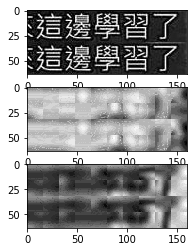

In [6]:
def normalize(x):
    x = x.convert("YCbCr")
    im = np.array(x, dtype=np.float)
    a = -0.5
    b = 0.5
    y = np.zeros([im.shape[2], im.shape[0], im.shape[1]], dtype=np.float)
    for i in range(3):
        minimum = np.min(im[:,:,i])
        maximum = np.max(im[:,:,i])
        delta = max(maximum - minimum, 0.01)
        y[i,:,:] = a + ((im[:,:,i] - minimum) * (b - a)) / delta
        # print(minimum, maximum)
    return y

im = normalize(x)

plt.subplots(3, 1)
for i in range(3):
    plt.subplot(3, 1, i + 1)
    plt.imshow(im[i,:,:], cmap='gray')

In [7]:
np.max(im[1,:,:])

0.5

In [8]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 32, 5, 2),
            nn.ReLU(),
            nn.Conv2d(32, 32, 3),
            nn.ReLU(),
            nn.Conv2d(32, 32, 3),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.50),
        )
        self.mlp = nn.Sequential(
            nn.Linear(15392, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 1),
        )
        self.optimizer = optim.Adam(self.parameters())
        self.loss = None

    def forward(self, x):
        x = self.cnn(x)
        # print(x.shape, np.prod(x.shape[1:]))
        
        x = x.view(-1, 15392)
        x = self.mlp(x)
        return x

    def train_data(self, data, target):
        self.optimizer.zero_grad()
        output = self.forward(data)
        self.loss = nn.functional.binary_cross_entropy_with_logits(output, target)
        self.loss.backward()
        self.optimizer.step()

model = Net().to(device)
model

Net(
  (cnn): Sequential(
    (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(2, 2))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.5, inplace=False)
  )
  (mlp): Sequential(
    (0): Linear(in_features=15392, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=128, out_features=1, bias=True)
  )
)

In [9]:
MODEL_NAME = "model2.mdl"
if os.path.isfile(MODEL_NAME):
    print(MODEL_NAME)
    model.load_state_dict(torch.load(MODEL_NAME))

In [10]:
im.shape

(3, 64, 160)

In [11]:
x = torch.randn(64, 3, 64, 160).to(device)
y = model.forward(x)

In [41]:
TRAIN_MODEL = True

if TRAIN_MODEL:
    # read training data
    ccfiles = glob.glob("TRAIN_DIFF_CC/*.jpg")
    ncfiles = glob.glob("TRAIN_SAME_CC/*.jpg")

    n1 = len(ccfiles)
    n2 = len(ncfiles)
    print(n1, n2)

1384 3931


In [42]:
if TRAIN_MODEL:
    data = np.zeros((n1+n1, 3, 64, 160), dtype=np.float)
    target = np.zeros((n1+n1,1), dtype=np.float)
    target[:n1] = 1
    print(data.shape, target.shape)

(2768, 3, 64, 160) (2768, 1)


In [43]:
if TRAIN_MODEL:
    for i in range(n1):
        fname = ccfiles[i]
        data[i, :, :, :] = normalize(Image.open(fname))
    
    nxfiles = ncfiles[101::2]
    nxfiles = nxfiles[-n1:]
    for i in range(n1):
        fname = nxfiles[i]
        data[i+n1, :, :, :] = normalize(Image.open(fname))

In [44]:
len(nxfiles)

1384

In [45]:
if TRAIN_MODEL:
    train_set = Data.TensorDataset(torch.from_numpy(data).float(), 
                                   torch.from_numpy(target).float())
    train_loader = Data.DataLoader(train_set, batch_size=256, shuffle=True, **kwargs)

    def trainModel(model, device, train_loader, epoch):
        model.train()
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            model.train_data(data, target)

        if epoch % 10 == 9:
            print('Train Epoch: {:3d} [{}]\tLoss: {:.6f}'.format(
                epoch + 1, len(train_loader.dataset), model.loss.item()))

In [46]:
if TRAIN_MODEL:
    N = 200
    for epoch in range(N):
        trainModel(model, device, train_loader, epoch)

Train Epoch:  10 [2768]	Loss: 0.033126
Train Epoch:  20 [2768]	Loss: 0.004939
Train Epoch:  30 [2768]	Loss: 0.010229
Train Epoch:  40 [2768]	Loss: 0.012984
Train Epoch:  50 [2768]	Loss: 0.011518
Train Epoch:  60 [2768]	Loss: 0.004605
Train Epoch:  70 [2768]	Loss: 0.015916
Train Epoch:  80 [2768]	Loss: 0.004036
Train Epoch:  90 [2768]	Loss: 0.012499
Train Epoch: 100 [2768]	Loss: 0.011722
Train Epoch: 110 [2768]	Loss: 0.003934
Train Epoch: 120 [2768]	Loss: 0.030737
Train Epoch: 130 [2768]	Loss: 0.009003
Train Epoch: 140 [2768]	Loss: 0.002181
Train Epoch: 150 [2768]	Loss: 0.003594
Train Epoch: 160 [2768]	Loss: 0.009963
Train Epoch: 170 [2768]	Loss: 0.002171
Train Epoch: 180 [2768]	Loss: 0.003544
Train Epoch: 190 [2768]	Loss: 0.002378
Train Epoch: 200 [2768]	Loss: 0.009613


In [47]:
def predictModel(model, test):
    model.eval()
    with torch.no_grad():
        testX = torch.from_numpy(test).float().to(device)
        predict = model(testX).cpu()
    predict = np.where(predict > 0, 1, 0)
    return predict

In [48]:
if TRAIN_MODEL:
    n = len(target)
    M = (n + 1023) // 1024
    for i in range(M):
        if i == M-1:
            xdata = data[i*1024:, :, :, :]
            xtarget = target[i*1024:]
        else:
            xdata = data[i*1024:(i+1)*1024, :, :, :]
            xtarget = target[i*1024:(i+1)*1024]
            
        y = predictModel(model, xdata)
        err = np.sum(np.abs(y - xtarget))
        print(i, err)    

0 0.0
1 0.0
2 0.0


In [49]:
if TRAIN_MODEL:
    torch.save(model.state_dict(), MODEL_NAME)

In [50]:
# read training data
ccfiles = glob.glob("TEMP/CC2/*.jpg")
n = len(ccfiles)
n

2453

In [51]:
def classified(files):
    n = len(files)
    test = np.zeros((n, 3, 64, 160), dtype=np.float)
    for i in range(n):
        fname = files[i]
        test[i, :, :, :] = normalize(Image.open(fname))
        
    y = predictModel(model, test)
    
    for i in range(n):
        fname = files[i]
        if y[i] == 1:
            outfile = fname.replace('CC2\\', 'CC2_DIFF\\')
        else:
            outfile = fname.replace('CC2\\', 'CC2_SAME\\')            
        shutil.copyfile(fname, outfile)


M = (n + 1023) // 1024
for i in range(M):
    if i == M-1:
        files = ccfiles[i*1024:]
    else:
        files = ccfiles[i*1024:(i+1)*1024]

    classified(files)